In [1]:
#!/usr/bin/python
import nltk
import numpy as np
import re
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from random import randint
from sklearn.model_selection import train_test_split
import random
import pandas as pd
import itertools
from nltk.stem.wordnet import WordNetLemmatizer 

Importing Glove and  40000 words list 

In [2]:
wordsList = np.load('wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')
print(len(wordsList))
print(wordVectors.shape)
print(wordsList[5066])
print(wordVectors[5066][:])

Loaded the word list!
Loaded the word vectors!
400000
(400000, 50)
closure
[ 0.50653   0.12284  -0.11653  -0.21052  -1.0672   -0.17536   0.16253
  0.76781   0.25517  -0.15995   0.025424 -0.65425  -0.44638  -0.19395
  0.45319   1.0955    0.050096 -0.36712   0.1729    0.28393   0.85448
 -0.54932  -1.1816    0.066158 -0.58561  -0.84893   0.1947    0.37832
  0.94141   0.62982   2.3869   -0.41035  -0.11599   0.049907 -0.41563
 -0.056999  1.5044   -0.93772  -0.16045   0.80019  -0.44448  -0.50036
  0.065875  0.27778  -0.27505  -0.012317 -0.37458   0.49171  -0.35498
  0.035347]


Importing the Dataset 

In [10]:
#--------------------Extracting Emotion && sentences from corpus
def extract(dataset):
    f = open(dataset, 'r+', encoding='utf-8')
    linea = f.readline()
    emotion = []
    sentences = []
    neutro = re.compile('^ne')
    while linea != "":    
        #Ignoramos Neutro emotions
        if not re.match(neutro, linea):
            #print("** ",linea)
            linea = linea.split("**@**")
            #Obtaining the emocion
            emotion.append(linea[2])
            sentences.append(linea[1])
        linea = f.readline()
    f.close()
    return sentences,emotion

dataset = "TwitterDataset/Train/train_valid_test.txt"
sentences,emotions = extract(dataset)
print(emotions[0]," ",sentences[0])
print("Labels: ",len(emotions), "Sentences: ",len(sentences))

anger   How the fu*k! Who the heck! moved my fridge!... should I knock the landlord door. #angry #mad ##
Labels:  7102 Sentences:  7102


In [11]:
import csv
with open('TwitterDataset/Train/train_valid_test.csv', mode='w', encoding='utf-8') as emo_file:
    emo_writer = csv.writer(emo_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    emo_writer.writerow(['Emotion', 'Sentence'])
    for i in range(0,len(emotions)):
        emo_writer.writerow([emotions[i],sentences[i]])
    
train = pd.read_csv("TwitterDataset/Train/train_valid_test.csv", delimiter=",")
train.head()

,Emotion,Sentence
0,anger,How the fu*k! Who the heck! moved my fridge!.....
1,anger,So my Indian Uber driver just called someone t...
2,anger,@DPD_UK I asked for my parcel to be delivered ...
3,anger,so ef whichever butt wipe pulled the fire alar...
4,anger,Don't join @BTCare they put the phone down on ...


Cuánto hay de cada emoción

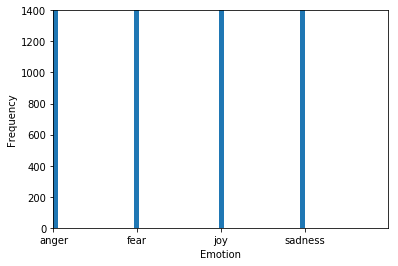

In [12]:
import matplotlib.pyplot as plt
import collections
%matplotlib inline
def histograma(emotion):
    #print(emotion)
    plt.hist(emotion, 50)
    plt.xlabel('Emotion')
    plt.ylabel('Frequency')
    plt.axis([0, 4, 0, 1400])
    plt.show()
histograma(emotions)

Preprocesing of Sentences

In [13]:
def decontracted(phrase):
    # specific
    '''phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)'''

    if phrase == "t":
        phrase = "not"
    elif phrase == "re":
        phrase = "are"
    elif phrase == "s":
        phrase = "is"
    elif phrase == "d":
        phrase = "would"
    elif phrase == "ve":
        phrase = "have"
    elif phrase == "m":
        phrase = "am"
    elif phrase == "ca":
        phrase = "can"
    elif phrase == "isn":
        phrase = "is"
    elif phrase == "aren":
        phrase = "are"
    elif phrase == "wouldn":
        phrase = "would"
    elif phrase == "don":
        phrase = "do"
    elif phrase == "wasn":
        phrase = "was"
    elif phrase == "weren":
        phrase = "were"

    # general
    '''phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)'''
    return phrase

In [14]:
def translator(user_string):
    user_string = user_string.lower()
    user_string = WordPunctTokenizer().tokenize(user_string)
    j = 0
    for _str in user_string:
        # File path which consists of Abbreviations.
        fileName = "TwitterDataset/slang.txt"
        # File Access mode [Read Mode]
        accessMode = "r"
        with open(fileName, accessMode) as myCSVfile:
            # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
            dataFromFile = csv.reader(myCSVfile, delimiter="=")
            # Removing Special Characters.
            _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
            for row in dataFromFile:
                # Check if selected word matches short forms[LHS] in text file.
                if _str.upper() == row[0]:
                    # If match found replace it with its Abbreviation in text file.
                    user_string[j] = row[1].lower()
            myCSVfile.close()
        j = j + 1
    return user_string

In [15]:
#----------------Cleanning Sentences--------------
lem = WordNetLemmatizer()
def clean_text(text, remove_stopwords=False):
    '''Clean the text, with the option to remove stopwords'''
    #Remove @user or http://...
    text = re.sub(r"(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text) 

    # Translate OMG to Oh My God
    text = translator(text)
    #Decontracs
    for w in range (0,len(text)):
        text[w] = decontracted(text[w])

    # Convert words to lower case and split them
    #text = text.lower()#.split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"<br />", " ", text)
    text = re.sub(r"[^a-z]", " ", text)
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    text = re.sub(r"  ", " ", text)
    
    #Lematize && itertools Ejmp: looove to love
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    text = lem.lemmatize(text, "v")
    
    # Return a list of words
    return(text)


train_clean = []
for sentence in train.Sentence:
    train_clean.append(clean_text(sentence))

In [16]:
# Inspect the cleaned reviews
for i in range(3):
    print(sentences[i])
    print(train_clean[i])
    print()

How the fu*k! Who the heck! moved my fridge!... should I knock the landlord door. #angry #mad ##
how the fu k who the heck moved my fridge should i knock the landlord door angry mad

So my Indian Uber driver just called someone the N word. If I wasn't in a moving vehicle I'd have jumped out #disgusted 
so my indian uber driver just called someone the n word if i was not in a moving vehicle i would have jumped out disgusted

@DPD_UK I asked for my parcel to be delivered to a pick up store not my address #fuming #poorcustomerservice
i asked for my parcel to be delivered to a pick up store not my address fuming poorcustomerservice



Les't determine the total and average number of words in each sentencesLes't determine the total and average number of words in each sentences

In [17]:
def maximum(sent):
    numWords = []
    for s in sent:
        counter = len(s)
        numWords.append(counter) 
    maxLengh = int(sum(numWords)/len(numWords))
    print("Average: ", maxLengh)
    return numWords,maxLengh
numWords,maxSeqLength = maximum(train_clean)

Average:  83


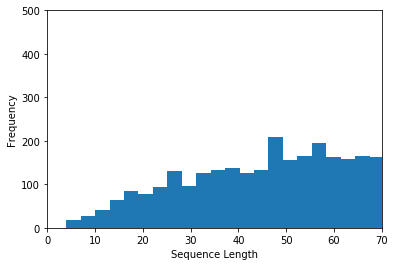

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
def histograma(numWords):
    plt.hist(numWords, 50)
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.axis([0, 70, 0, 500])
    plt.show()
histograma(numWords)

Converting each sentence into a vector and adding it into a matrix of 'ids'

In [19]:
def integerSenteces(sent,maximum):
    i = 0
    embbeding = 0
    matrix = np.zeros((len(sent), maximum)) #250 X 6 (numEjem X Maximun)
    for s in sent:
        vector = np.zeros((maximum), dtype='int32')
        s =  s.split()
        bound = maximum
        if len(s) < maximum:
            bound = len(s)    
        for token in range(0,bound): #No encuentra macu, porque la corta
            if s[token] not in wordsList:
                vector[token] = embbeding # ???
                #---print(s[token])
            else:
                vector[token] = (wordsList.index(s[token]))
                embbeding = vector[token]
        matrix[i] = (vector)
        i += 1
    return matrix

In [20]:
X = integerSenteces(train_clean,maxSeqLength) 
print("Sentences integer representation: ",(X.shape))
print("Sentences: ",len(train_clean))
print("Integer format: ",X[249])
print("Normal format: ",train_clean[249])

Sentences integer representation:  (7102, 83)
Sentences:  7102
Integer format:  [8.100e+01 4.300e+01 3.320e+02 5.960e+02 1.318e+03 3.800e+01 4.146e+03
 8.100e+01 1.170e+02 4.100e+01 1.190e+02 5.000e+00 1.200e+01 1.920e+02
 8.350e+02 4.300e+01 3.000e+01 1.920e+02 5.476e+03 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
Normal format:  you will never find someone who loved you like i did and that

In [21]:
def toClasses(emo):
    id_emo = []
    for e in emo:
        e = e.split()
        e = e[0]
        if e == 'joy':
            e = 1
        elif e == 'sadness':
            e = 2
        elif e == 'anger':
            e = 3
        elif e == 'fear':
            e = 4
            
        id_emo.append(e)
    return id_emo
emotions = toClasses(emotions)
print(emotions[0]," ",sentences[0])

3   How the fu*k! Who the heck! moved my fridge!... should I knock the landlord door. #angry #mad ##


Split the Data (stratify) into : Train && Test Sets

In [22]:
print("Sentences: ",len(X),"  Labels: ",len(emotions))
X_train, X_test, Y_train, Y_test = train_test_split(X, emotions, test_size=0.20, random_state=random.randrange(50), stratify=emotions)
print("X_train: ",len(X_train),"  Y_train: ",len(Y_train),"  X_test: ",len(X_test),"  Y_test: ",len(Y_test))

Sentences:  7102   Labels:  7102
X_train:  5681   Y_train:  5681   X_test:  1421   Y_test:  1421


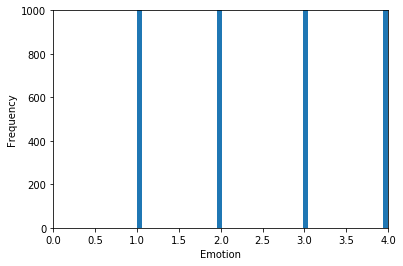

*****************


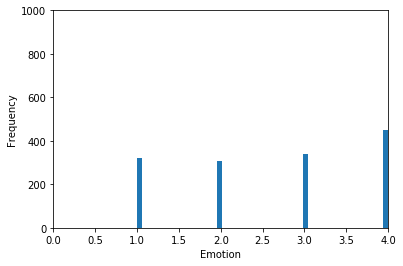

In [23]:
import matplotlib.pyplot as plt
import collections
%matplotlib inline
def histograma(emotion):
    #print(emotion)
    plt.hist(emotion, 50)
    plt.xlabel('Emotion')
    plt.ylabel('Frequency')
    plt.axis([0, 4, 0, 1000])
    plt.show()
histograma(Y_train)
print("*****************")
histograma(Y_test)
#for i in range (0,len(X_train)):
 #   print(Y_train[i],"  ",X_train[i])

Converting the Labels into Onehot Vectors

In [24]:
def toLabels(emo):
    classes = 4
    Y = np.zeros((len(emo), classes)) #Num Ejemplos X 4 emociones
    for e in range(0,len(emo)):
        vector = np.zeros((classes))
        vector[(emo[e] % (classes + 1)) - 1] = 1 
        Y[e] = vector
        #print(emo[e],"---",vector)
    return Y
 
Y_train = toLabels(Y_train)
Y_test = toLabels(Y_test)

In [25]:
print("Y_train: ",Y_train.shape," Num Ejem X # clases")
print("X_train: ",X_train.shape," Num Ejem X Maximun Lengh")
print("Y_test: ",Y_test.shape," Num Ejem X # clases")
print("X_test: ",X_test.shape," Num Ejem X Maximun Lengh")

Y_train:  (5681, 4)  Num Ejem X # clases
X_train:  (5681, 83)  Num Ejem X Maximun Lengh
Y_test:  (1421, 4)  Num Ejem X # clases
X_test:  (1421, 83)  Num Ejem X Maximun Lengh


RNN Model

In [26]:
batchSize = 299 #Tiene que ser multiplo del NumEjem
lstmUnits = 64
numClasses = 4

Declarando placeholders para los labels (6 emotions) && data imput

In [27]:
import tensorflow as tf
tf.reset_default_graph()
numDimensions = 300 

#labels = tf.placeholder(tf.float32, [batchSize, numClasses])
#input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])
labels = tf.placeholder(tf.float32, [None, numClasses])
input_data = tf.placeholder(tf.int32, [None, maxSeqLength])

Embeddings: Le damos el formato a nuestra data, aún no compilamos nada, solo declaramos

In [28]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

LSTM Model

In [29]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

In [30]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

In [31]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

In [32]:
learning_rate = 0.001
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

C:\Users\danie\Anaconda3\envs\Compositor\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Tensorboar

In [33]:
import datetime
def board(sess):
    tf.summary.scalar('Loss', loss)
    tf.summary.scalar('Accuracy', accuracy)
    tf.summary.histogram("Histogrma/hAccu", accuracy)
    merged = tf.summary.merge_all()
    logdir = "board/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
    writer = tf.summary.FileWriter(logdir, sess.graph)
    return merged,writer

Confusion Matrix Plot

In [36]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [41]:
# Initializing the variables
init = tf.global_variables_initializer()
display_step = 10
numEjemplos = 5681         
iterations = 300

X_train:  5681   Y_train:  5681   X_test:  1421   Y_test:  1421
Epoch: 0001 cost= 1.377037237  accuracy= 31.086076482
Epoch: 0011 cost= 1.127716604  accuracy= 47.878894837
Epoch: 0021 cost= 0.937563015  accuracy= 58.422813290
Epoch: 0031 cost= 0.814160673  accuracy= 64.566097761
Epoch: 0041 cost= 0.661553709  accuracy= 73.437774809
Epoch: 0051 cost= 0.740738489  accuracy= 69.371589861
Epoch: 0061 cost= 0.469520512  accuracy= 82.749515772
Epoch: 0071 cost= 0.484342589  accuracy= 81.904594835
Epoch: 0081 cost= 0.342640695  accuracy= 87.590212571
Epoch: 0091 cost= 0.347097190  accuracy= 87.079739571
Epoch: 0101 cost= 0.356351472  accuracy= 87.062136750
Epoch: 0111 cost= 0.252907857  accuracy= 91.128322325
Epoch: 0121 cost= 0.474563109  accuracy= 83.013553682
Epoch: 0131 cost= 0.244263611  accuracy= 91.462769634
Epoch: 0141 cost= 0.240215539  accuracy= 92.026051408
Epoch: 0151 cost= 0.212156776  accuracy= 92.923781119
Epoch: 0161 cost= 0.144917706  accuracy= 94.930469676
Epoch: 0171 cost= 

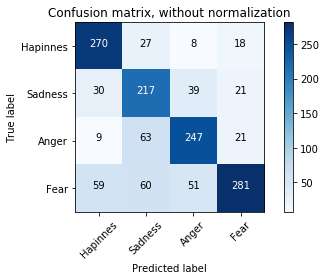

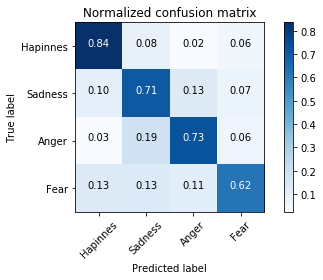

In [42]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    #Calling tensorboard function
    #---merged,writer = board(sess)
    print("X_train: ",len(X_train),"  Y_train: ",len(Y_train),"  X_test: ",len(X_test),"  Y_test: ",len(Y_test))

    # Training cycle
    for epoch in range(iterations):
        avg_cost = 0.
        avg_accu = 0.
        total_batch = int(numEjemplos/batchSize)
        #Create X groups of (50,6) Labels && (50,maximum) Examples
        X_batches = np.array_split(X_train, total_batch)
        Y_batches = np.array_split(Y_train, total_batch)
        
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = X_batches[i], Y_batches[i]
            #print("X: ",batch_x.shape)
            #print("Y: ",batch_y.shape)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c , accu= sess.run([optimizer, loss, accuracy], feed_dict={input_data: batch_x,
                                                          labels: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
            avg_accu += accu / total_batch

            #Write summary to Tensorboard
            '''if (epoch % 10 == 0):
                summary = sess.run(merged, {input_data: batch_x, labels: batch_y})
                writer.add_summary(summary, epoch)'''
            

            #Save the network every 10,000 training iterations
            #if (i % 10000 == 0 and i != 0):
                # save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
                 # print("saved to %s" % save_path)
            #writer.close()

        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost)," accuracy=", "{:.9f}".format(avg_accu*100))
    print("Optimization Finished!")
    
    #Test Model LSTM  
    correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correctPred, "float"))
    print("Accuracy:", accuracy.eval({input_data: X_test, labels: Y_test}))
    
    #Matriz de confusion

    #print("Test Samples, Class Predictions: ")
    #----Result es mi tensor prediction convertido a np.array
    result = tf.argmax(prediction , 1).eval({input_data: X_test, labels: Y_test})
    #print(result.shape)
    
    
    #print("Test Samples: ")
    test = (tf.argmax(Y_test , 1).eval()) #Convierte de [0,0,1,0,0] a [2] y lo hace np.array
    #print(test.shape)
    #print("Conversion: ")
    #for i in range(0,len(test)):
        #print(test[i],"---",Y_test[i],"---",result[i])
      

    from sklearn.metrics import confusion_matrix
    y_true = test
    y_pred = result
    #print(confusion_matrix(y_true, y_pred))
    class_names = ["Hapinnes","Sadness","Anger","Fear"]

    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()


Heterogenio Dataset

In [55]:
#--------------------Extracting Emotion && sentences from corpus
def extract_2(dataset):
    f = open(dataset, 'r+')
    linea = f.readline()
    emotion = []
    sentences = []
    while linea != "":    
        linea = linea.split("#")
        linea[1] = linea[1].split()
        #print(linea[0]," ",linea[1])
        #Obtaining the emocion
        emotion.append(int(linea[0]))
        sentences.append(linea[1])
        linea = f.readline()
    f.close()
    return sentences,emotion

dataset = "TwitterDataset/Train/Heteroinfo.txt"
tail_sent,tail_emo = extract_2(dataset)
print(tail_emo[0]," ",tail_sent[0])
print("Labels: ",len(tail_emo), "Sentences: ",len(tail_sent))

2   ['6730.0', '2728.0', '2200.0', '22.0', '338.0', '519.0', '767.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
Labels:  2940 Sentences:  2940


In [62]:
def string_int(vector):
    for i in range(0,len(vector)):
        for j in range(0,len(vector[i])):
            vector[i][j] = float(vector[i][j])
    return vector

In [63]:
tail_sent = string_int(tail_sent)

In [64]:
print(tail_emo[0]," ",tail_sent[0])
print("Labels: ",len(tail_emo), "Sentences: ",len(tail_sent))

2   [6730.0, 2728.0, 2200.0, 22.0, 338.0, 519.0, 767.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Labels:  2940 Sentences:  2940


Convirtiendo Labels to hot vectors

In [ ]:
#Averogua ottros modelos
#Cambie el keep_drop
#Cambia learning rate
#Cambie num unidades 128?
#Prueba con tu modelo